# Creating cloud masks and generating atmospherically-corrected images
### Set instance (from sentinelhub free account (1 month trial!) and import relevant packages
#### Before running, make sure you start the docker so that the environments are correct - do this with: 
docker run -it --rm -p 8888:8888 -v $PWD/:/home/jovyan krostir/jupyter-geo-sentinelhub

OR just run from environment "atcor2"
#### For sentinelhub python package information visit https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html

In [2]:
INSTANCE_ID = 'ce54ab2b-9dc3-4592-8a37-bbc96d450750'  
# In case you put instance ID into configuration file you can leave this unchanged

In [3]:
from sentinelhub import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import pickle
import sys
import datetime
import numpy as np

sys.path.append('/home/maya/Dropbox/InternshipWUR/Scripting/git_workspace/S2DataProcessing/')
import matplotlib.pyplot as plt
from s2cloudless import *


from glob import glob
import os

import numpy.ma as ma
import pandas as pd
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns

import rasterio
import geopandas as gpd
from shapely.geometry import mapping

import earthpy as et
import earthpy.spatial as es

from osgeo import gdal, gdal_array, osr

plt.ion()
sns.set_style('white')
sns.set(font_scale=1.5)

os.chdir(os.path.join(et.io.HOME, 'Documents/USNInternship/Sentinel_Imagery/'))

#### Defining function to plot tiles

In [4]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

#### Define cloud masker functions

In [5]:
def overlay_cloud_mask(image, mask=None, factor=1./255, figsize=(15, 15), fig=None):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    rgb = np.array(image)
    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255, 255, 0, 100], dtype=np.uint8)
        plt.imshow(cloud_image)

In [6]:
def plot_probability_map(rgb_image, prob_map, factor=1./255, figsize=(15, 30)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 2, 1)
    plt.imshow(rgb_image * factor)
    plot = plt.subplot(1, 2, 2)
    plot.imshow(prob_map, cmap=plt.cm.inferno)

In [7]:
def plot_cloud_mask(mask, figsize=(15, 15), fig=None):
    """
    Utility function for plotting a binary cloud mask.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    plt.imshow(mask, cmap=plt.cm.gray)

In [8]:
def plot_previews(data, dates, cols=4, figsize=(15, 15)):
    """
    Utility to plot small "true color" previews.
    """
    width = data[-1].shape[1]
    height = data[-1].shape[0]
    
    rows = data.shape[0] // cols + (1 if data.shape[0] % cols else 0)
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for index, ax in enumerate(axs.flatten()):
        if index < data.shape[0]:
            caption = '{}: {}'.format(index, dates[index].strftime('%Y-%m-%d'))
            ax.set_axis_off()
            ax.imshow(data[index] / 255., vmin=0.0, vmax=1.0)
            ax.text(0, -2, caption, fontsize=12, color='g')
        else:
            ax.set_axis_off()

#### Setting AOI

In [20]:
hardangervidda_coords_wgs84 = [8.3018, 60.3967,6.7596,59.9] #rectangle for AOI
AOI = [8.212529728804157, 60.11440450337899, 8.025762150679157, 60.02086917002816] #AOI concentrated *5km buffer
hardanger_bbox = BBox(bbox=hardangervidda_coords_wgs84, crs=CRS.WGS84) #bounding box, interpretable by sentinelhub
studyarea = BBox(bbox=AOI, crs=CRS.WGS84) #bounding box, interpretable by sentinelhub

#### WMS request for multiple true colour images, within time window.
Width and height set - can also just set one, and the other will adjust automatically

In [21]:
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=studyarea,
                                    time=('2017-10-01', '2017-10-31'),
                                    width=600, #height=856,
                                    instance_id=INSTANCE_ID,
                                    maxcc=0.5,
                                    custom_url_params={CustomUrlParam.ATMFILTER: 'ATMCOR',
                                                   CustomUrlParam.TRANSPARENT: True,
                                                   CustomUrlParam.SHOWLOGO: False})

In [22]:
wms_true_color_img = wms_true_color_request.get_data()
#wms_true_color_img = wms_true_color_request.get_data()

In [23]:
wcs_true_color_request = WcsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=studyarea,
                                    time=('2017-10-01', '2017-10-31'),
                                    resx='10m', resy='10m',
                                    instance_id=INSTANCE_ID,
                                    maxcc=0.5,
                                    custom_url_params={CustomUrlParam.ATMFILTER: 'ATMCOR',
                                                   CustomUrlParam.TRANSPARENT: True,
                                                   CustomUrlParam.SHOWLOGO: False})

In [24]:
wcs_true_color_img = wcs_true_color_request.get_data()

In [25]:
print('There are %d Sentinel-2 images available for 2017.' % len(wms_true_color_img))
#print(type(wms_true_color_request.get_data()[1]))
#print(type(wms_true_color_img[1]))
#print(type(wms_true_color_request))

There are 5 Sentinel-2 images available for 2017.


#### Preview the data queried

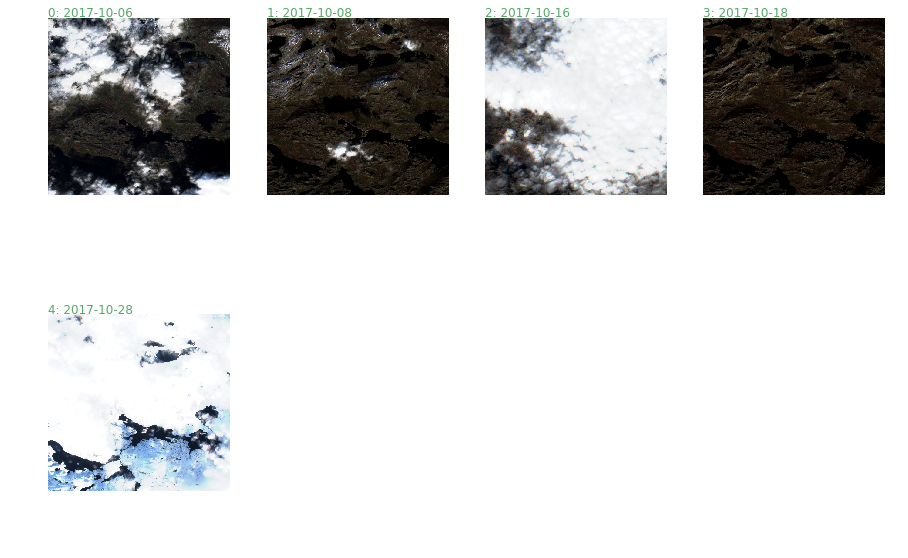

In [26]:
plot_previews(np.asarray(wms_true_color_img), wms_true_color_request.get_dates(), cols=4, figsize=(15, 10))

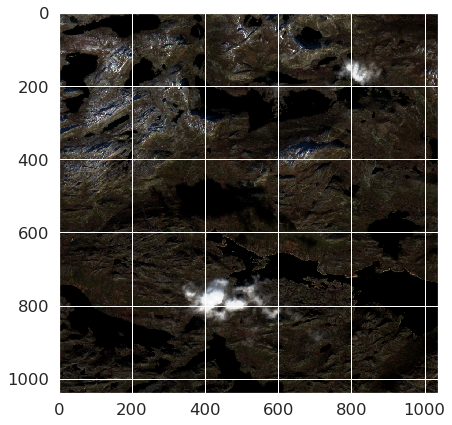

In [48]:
#plot_image(wms_true_color_img[4])
plot_image(wcs_true_color_img[1])

In [28]:
print('These %d images were taken on the following dates:' % len(wms_true_color_request.get_data()))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 5 images were taken on the following dates:
 - image 0 was taken on 2017-10-06 10:59:37
 - image 1 was taken on 2017-10-08 10:50:12
 - image 2 was taken on 2017-10-16 11:03:13
 - image 3 was taken on 2017-10-18 10:50:26
 - image 4 was taken on 2017-10-28 10:51:28


## Cloud Detection 
### Make a new WMS request - note: cannot have atmospheric correction activated - interferes with result

In [29]:
bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'

In [40]:
#Non-atmospherically corrected images - inputs for cloud detection
bands_request = WcsRequest(layer='TRUE-COLOR-S2-L1C',
                               custom_url_params={
                                   CustomUrlParam.EVALSCRIPT: bands_script,
                                   CustomUrlParam.ATMFILTER: 'NONE'},#or ATMCOR
                               bbox=studyarea,
                               maxcc=0.5,
                               time=('2017-10-01', '2017-10-30'), 
                               resx='10m', resy='10m',
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)

In [42]:
wcsbands = bands_request.get_data()
wcsbands[1].shape

(1040, 1037, 10)

In [32]:
#All raw bands, with atmospheric correction applied (extra layer 14 - transparency filter (nodata values))
wcs_allbands_request = WcsRequest(layer='BANDS-S2-L1C',
                                  custom_url_params={CustomUrlParam.ATMFILTER: 'ATMCOR',
                                                     CustomUrlParam.TRANSPARENT: True,
                                                     CustomUrlParam.SHOWLOGO: False},
                                  bbox=studyarea,
                                  maxcc=0.5,
                                  time=('2017-10-01', '2017-10-30'), 
                                  resx='10m', resy='10m',
                                  image_format=MimeType.TIFF_d32f,
                                  instance_id=INSTANCE_ID)

In [35]:
wcs_allbands=wcs_allbands_request.get_data()
wcs_allbands[1].shape

(1040, 1037, 14)

Image showing SWIR band 12

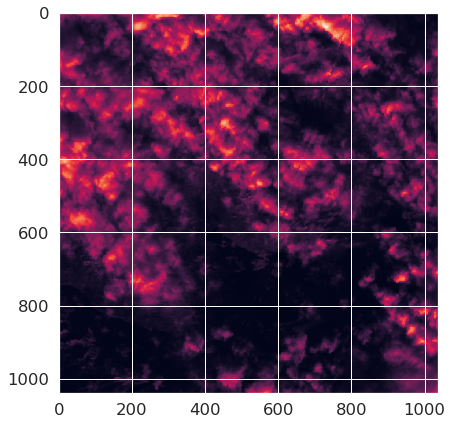

In [38]:
plot_image(wcs_allbands[4][:, :, 12])

Image showing true color (2.5 is some kind of contrast/histogram stretch to make it look clearer)

In [165]:
#plot_image(wcs_allbands[4][:, :, [3,2,1]],2.5)#rgb = '[3,2,1]', other bands can be specified too

In [43]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

/home/maya/anaconda2/envs/atcor2/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [44]:
cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(wcsbands))

In [45]:
cloud_masks = cloud_detector.get_cloud_masks(np.array(wcsbands))

### Visualise the results

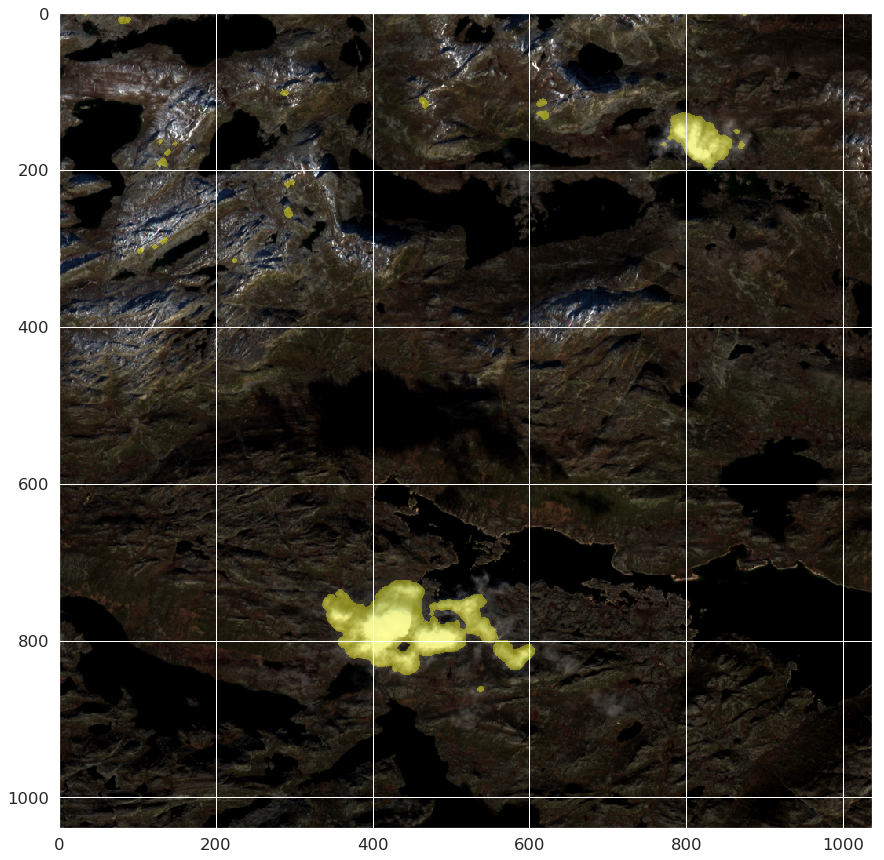

In [49]:
image_idx = 1
overlay_cloud_mask(wcs_true_color_img[image_idx], cloud_masks[image_idx])

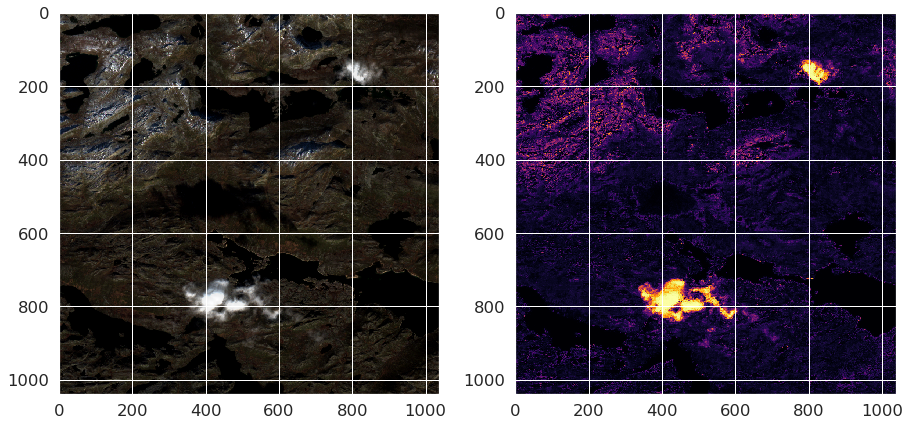

In [50]:
plot_probability_map(wcs_true_color_img[image_idx], cloud_probs[image_idx])

In [169]:
#plot_cloud_mask(cloud_masks[image_idx])

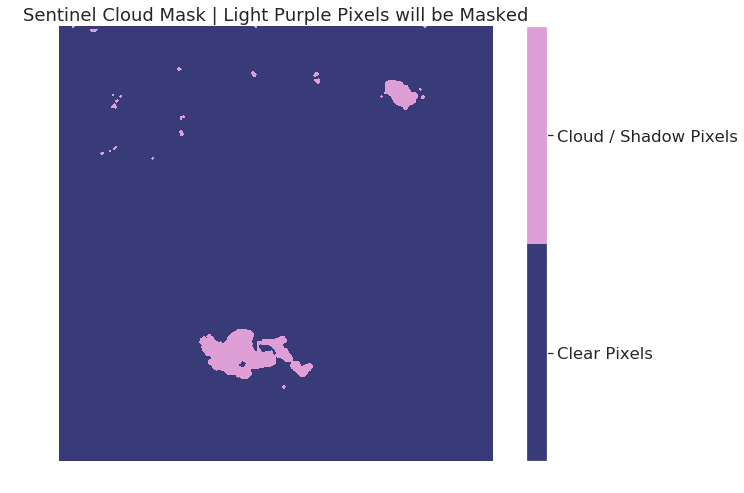

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud_masks[image_idx],
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Sentinel Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()

plt.show()

## Cloud Masking

In [52]:
print(cloud_masks.shape)
type(cloud_masks[1])

(5, 1040, 1037)


numpy.ndarray

In [53]:
#result = wms_true_color_img[image_idx].copy()
result= wcs_allbands[image_idx].copy()
mask2d=cloud_masks[image_idx].copy()
print(result.shape)
cloud_masks[image_idx].shape

(1040, 1037, 14)


(1040, 1037)

#### copy mask x times (equal to the total no. of bands)

In [54]:
mask3d = np.repeat(cloud_masks[image_idx][:, :, np.newaxis], 14, axis=2)
mask3d.shape

(1040, 1037, 14)

In [56]:
#plot_image(cloud_masks[4])
#plot_image(mask3d[:, :, 8]) #confirms that it is the same repeated over all "bands"

np.alltrue(mask3d[:,:,8] == cloud_masks[image_idx]) #checks that they are equal :) 

True

#### Create masked numpy arrays 
following solutions are two ways of doing the same thing and seem correct

In [57]:
sentinel_pre_mask = np.broadcast_to(mask3d==1, result.shape)
sentinel_pre_cl_free = np.ma.masked_array(result,mask=sentinel_pre_mask)

resultmasked = np.ma.masked_array(result,mask=mask3d,fill_value = 999999)
#resultmasked=np.ma.array(result,mask=mask3d)
resultmaskeddata=resultmasked.data

spm= np.broadcast_to(mask3d==1, result.shape)
spcf = np.ma.masked_array(result,mask=spm)

masked=spcf.data

np.unique(resultmasked.mask)

array([False,  True])

#### Visualisation! (Ideal = with holes where clouds were)

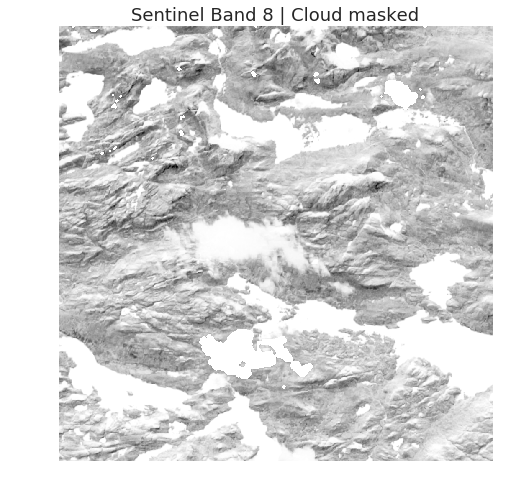

In [63]:
# This hasn't quite worked - cloud still visible (when true color band combo used)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.imshow(resultmasked[:,:,8],
          #extent=landsat_extent,
          cmap="Greys")
ax.set(title="Sentinel Band 8 | Cloud masked")
ax.set_axis_off()

plt.show()

## Export numpy arrays as TIFF files
Using Gdal (script from: https://gis.stackexchange.com/questions/293540/writing-a-raster-file-from-multi-dimension-array-using-python )

Also see: 
https://gis.stackexchange.com/questions/34082/creating-raster-layer-from-numpy-array-using-pyqgis

In [65]:
def CreateTiff(output, array, driver, noData, GeoT, Proj, DataType):

    rows = array.shape[0]
    cols = array.shape[1]
    band = array.shape[2]

    array[np.isnan(array)] = noData
    driver = gdal.GetDriverByName('GTiff')

    DataSet = driver.Create(output, cols, rows, band, gdal.GDT_Float32)
    DataSet.SetGeoTransform(GeoT)
    projec = osr.SpatialReference()
    projec.SetWellKnownGeogCS(Proj)
    DataSet.SetProjection(projec.ExportToWkt())
    #DataSet.SetProjection(Proj)
    
    for i in range(band):
        DataSet.GetRasterBand(i+1).WriteArray(array[:, :, i])
        DataSet.GetRasterBand(i+1).SetNoDataValue(noData)
    DataSet.FlushCache()
    return 'Success!'

In [66]:
output_file = 'rastertester'
input_array = resultmaskeddata
xres = (hardangervidda_coords_wgs84[0]-hardangervidda_coords_wgs84[2])/float(resultmasked.shape[0])
yres = (hardangervidda_coords_wgs84[1]-hardangervidda_coords_wgs84[3])/float(resultmasked.shape[1])
xmin=hardangervidda_coords_wgs84[2] 
ymax=hardangervidda_coords_wgs84[1]

GeoTransform = [xmin,10,0,ymax,0,-10] #or xres and -yres for the cell size arguments 
Projection = "EPSG:4326" #ESPG code for EGS84
#srs=osr.SpatialReference()
#srs.ImportFromEPSG(Projection)
driver='GTiff'
noData=-999999

DataType='gdal.GDT_Float32'

# Writes raster
CreateTiff(output_file, input_array, driver, noData, 
           GeoTransform, Projection, DataType)

'Success!'

### Other possible options:
ArcPy: https://pro.arcgis.com/en/pro-app/arcpy/functions/numpyarraytoraster-function.htm  

Rasterio: 
https://forum.sentinel-hub.com/t/how-to-save-return-data-as-geotiff/218/2 OR
https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-in-python/export-numpy-array-to-geotiff-in-python/

Pyqgis to convert to tiff: https://www.hatarilabs.com/ih-en/how-to-convert-a-matrix-in-a-geospatial-tiff-in-qgis-with-pyqgis-tutorial

## Check out following sources:
### more assistance on masking over multiple dimensions perhaps...
https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/ 
https://geohackweek.github.io/nDarrays/09-masking/ 